<h1>Mapas estacionales de campos de velocidades</h1>

<h3>Tener en cuenta que las corrientes superficiales en el Mar Caribe son:</h3>
</br>CG - Corriente de Guyana
</br>NEC - Corriente Ecuatorial del Norte
</br>sCC - Corriente del Caribe Sur
</br>nCC - Corriente del Caribe Norte
</br>GPC - Giro Panamá Colombia
</br>CC - Corriente del Caribe


Importamos nuestras librerías

In [1]:
import xarray as xr
import numpy as np
import skimage
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

In [2]:
ds_currents = xr.open_dataset('..\Data\corrientes_u_v_5m_enero1993_diciembre2020.nc')
ds_currents

<xarray.Dataset>
Dimensions:    (depth: 5, latitude: 205, time: 336, longitude: 372)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 3.819 5.078
  * latitude   (latitude) float32 7.0 7.083 7.167 7.25 ... 23.83 23.92 24.0
  * time       (time) datetime64[ns] 1993-01-16T12:00:00 ... 2020-12-16T12:00:00
  * longitude  (longitude) float32 -89.92 -89.83 -89.75 ... -59.17 -59.08 -59.0
Data variables:
    vo         (time, depth, latitude, longitude) float32 ...
    uo         (time, depth, latitude, longitude) float32 ...
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

Dividimos en meses

In [3]:
ds_monthly = ds_currents.groupby('time.month').mean()
ds_monthly

<xarray.Dataset>
Dimensions:    (depth: 5, latitude: 205, month: 12, longitude: 372)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 3.819 5.078
  * latitude   (latitude) float32 7.0 7.083 7.167 7.25 ... 23.83 23.92 24.0
  * longitude  (longitude) float32 -89.92 -89.83 -89.75 ... -59.17 -59.08 -59.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    vo         (month, depth, latitude, longitude) float32 0.1063 ... 0.02531
    uo         (month, depth, latitude, longitude) float32 0.1706 ... -0.002202
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

Definimos una fución para generar los mapas

In [8]:
def generar_mapa(data, temporada):    
    
    lat = data['latitude'].to_numpy()
    lon = data['longitude'].to_numpy()
    V = data["vo"].mean(dim=["month","depth"]).to_numpy()
    U = data["uo"].mean(dim=["month","depth"]).to_numpy()

    X, Y = np.meshgrid(lon, lat)

    x = skimage.measure.block_reduce(X, (10, 10), np.nanmean)
    y = skimage.measure.block_reduce(Y, (10, 10), np.nanmean)
    u = skimage.measure.block_reduce(U, (10, 10), np.nanmean)
    v = skimage.measure.block_reduce(V, (10, 10), np.nanmean)

    # Crea una figura y ejes con la proyección de latitud y longitud
    fig, ax = plt.subplots(1, figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    loc = ticker.MultipleLocator(4)

    # Agrega el mapa base (costas, límites de países, etc.)
    ax.add_feature(cf.COASTLINE)
    ax.add_feature(cf.BORDERS)

    # Genera una capa raster
    R = ax.imshow(np.sqrt(U**2 + V**2), extent=[lon.min(), lon.max(), lat.min(), lat.max()],
            cmap='gist_ncar', origin='lower', vmin=0, vmax=1)


    # Crea el gráfico de vectores
    Q = ax.quiver(x, y, u, v, np.sqrt(u**2 + v**2), scale=10, color= 'w')

    # Crea una lista con las longitudes de los puntos
    lat_p = [17.25, 13, 10, 14]
    lon_p = [-74, -73, -77, -80]

    # Usa plt.scatter para crear un gráfico de dispersión con los puntos
    plt.scatter(lon_p, lat_p, color='red', marker='+', s=50)

    # Define las coordenadas y las marcas para los puntos
    lat_c = [11, 14, 13, 17.5, 10, 18]
    lon_c = [-62, -61, -70, -72, -79, -84 ]
    marcas = ['CG', 'NEC', 'sCC', 'nCC', 'GPC', 'CC']

    # Grafica las marcas con las coordenadas correspondientes usando plt.text
    for i, texto in enumerate(marcas):
        ax.text(lon_c[i], lat_c[i], texto, color= "black", fontsize=11, fontweight='bold', ha='center', va='center', transform=ccrs.Geodetic())

    # Agrega una barra de color asociada a la magnitud de los vectores
    plt.colorbar(R, label=r"Velocidad [$\frac{m}{s}$]", shrink = 0.5, extend = 'both')

    # Establece los límites del mapa y etiquetas de los ejes
    ax.set(ylim=(lat.min(), lat.max()), xlim=(lon.min(), lon.max()))

    # Agrega un marco con las coordenadas
    ax.gridlines(draw_labels={"bottom": "x", "left": "y"}, xlocs=loc, ylocs=loc)

    # Muestra el mapa
    plt.title(f"Velocidades de Corrientes superficiales de {temporada} (1993-2020)")
    plt.show()
    
    fig.savefig("..\Imagenes\Mapas_estacionales\{}.png".format(temporada), dpi = 500, bbox_inches = 'tight')

<h3>DEF: Diciembre, Enero y Febrero</h3>

In [5]:
ds_DEF = ds_monthly.sel({'month': [12, 1, 2]})
ds_DEF

<xarray.Dataset>
Dimensions:    (depth: 5, latitude: 205, month: 3, longitude: 372)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 3.819 5.078
  * latitude   (latitude) float32 7.0 7.083 7.167 7.25 ... 23.83 23.92 24.0
  * longitude  (longitude) float32 -89.92 -89.83 -89.75 ... -59.17 -59.08 -59.0
  * month      (month) int64 12 1 2
Data variables:
    vo         (month, depth, latitude, longitude) float32 0.05988 ... -0.008066
    uo         (month, depth, latitude, longitude) float32 0.23 ... 0.02803
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

c:\Users\neybe\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\measure\block.py:89: RuntimeWarning: Mean of empty slice
  return func(blocked, axis=tuple(range(image.ndim, blocked.ndim)),


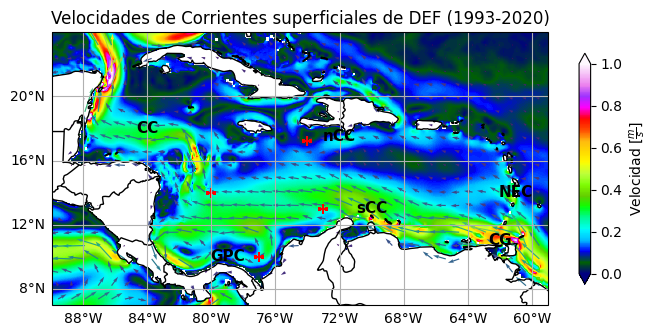

In [9]:
generar_mapa(ds_DEF, 'DEF')

<h3>MAM: Marzo, Abril y Mayo</h3>

In [10]:
ds_MAM = ds_monthly.sel({'month': [3, 4, 5]})
ds_MAM

<xarray.Dataset>
Dimensions:    (depth: 5, latitude: 205, month: 3, longitude: 372)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 3.819 5.078
  * latitude   (latitude) float32 7.0 7.083 7.167 7.25 ... 23.83 23.92 24.0
  * longitude  (longitude) float32 -89.92 -89.83 -89.75 ... -59.17 -59.08 -59.0
  * month      (month) int64 3 4 5
Data variables:
    vo         (month, depth, latitude, longitude) float32 0.05624 ... 0.02579
    uo         (month, depth, latitude, longitude) float32 0.2921 ... -0.01923
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

c:\Users\neybe\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\measure\block.py:89: RuntimeWarning: Mean of empty slice
  return func(blocked, axis=tuple(range(image.ndim, blocked.ndim)),


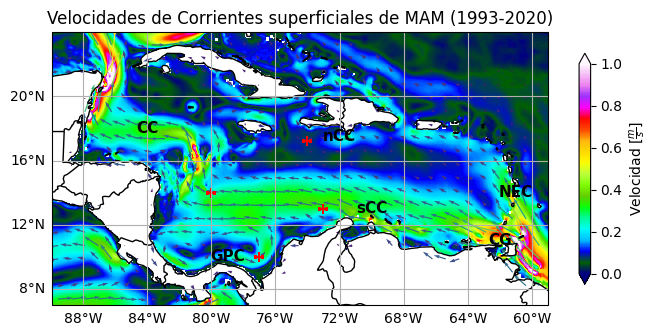

In [11]:
generar_mapa(ds_MAM,'MAM')

<h3>JJA: Junio, Julio y Agosto</h3>

In [12]:
ds_JJA = ds_monthly.sel({'month': [6, 7, 8]})
ds_JJA

<xarray.Dataset>
Dimensions:    (depth: 5, latitude: 205, month: 3, longitude: 372)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 3.819 5.078
  * latitude   (latitude) float32 7.0 7.083 7.167 7.25 ... 23.83 23.92 24.0
  * longitude  (longitude) float32 -89.92 -89.83 -89.75 ... -59.17 -59.08 -59.0
  * month      (month) int64 6 7 8
Data variables:
    vo         (month, depth, latitude, longitude) float32 -0.03272 ... 0.04698
    uo         (month, depth, latitude, longitude) float32 0.2893 ... -0.002529
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

c:\Users\neybe\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\measure\block.py:89: RuntimeWarning: Mean of empty slice
  return func(blocked, axis=tuple(range(image.ndim, blocked.ndim)),


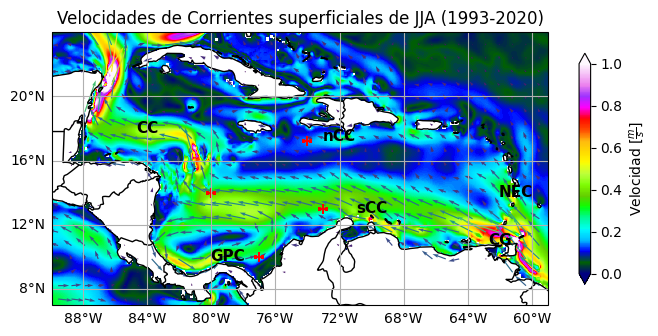

In [14]:
generar_mapa(ds_JJA,'JJA')

<h3>SON: Septiembre, Octubre y Noviembre</h3>

In [15]:
ds_SON = ds_monthly.sel({'month': [9, 10, 11]})
ds_SON

<xarray.Dataset>
Dimensions:    (depth: 5, latitude: 205, month: 3, longitude: 372)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 3.819 5.078
  * latitude   (latitude) float32 7.0 7.083 7.167 7.25 ... 23.83 23.92 24.0
  * longitude  (longitude) float32 -89.92 -89.83 -89.75 ... -59.17 -59.08 -59.0
  * month      (month) int64 9 10 11
Data variables:
    vo         (month, depth, latitude, longitude) float32 -0.0667 ... 0.016
    uo         (month, depth, latitude, longitude) float32 0.3436 ... 0.01338
Attributes: (12/17)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

c:\Users\neybe\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\measure\block.py:89: RuntimeWarning: Mean of empty slice
  return func(blocked, axis=tuple(range(image.ndim, blocked.ndim)),


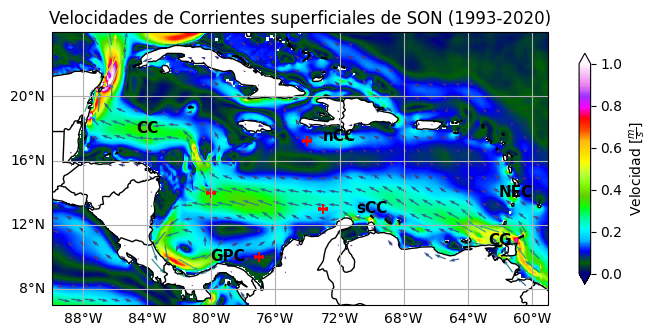

In [16]:
generar_mapa(ds_SON,'SON')